In [1]:
# Libraries
import numpy as np
import pandas as pd
import bz2
import csv
from sklearn.metrics import roc_auc_score
import seaborn as sns
from tqdm.notebook import tqdm
import re

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

In [2]:
# Load the training data
path_to_train_data = "/kaggle/input/amazonreviews/train.ft.txt.bz2"
data = bz2.BZ2File(path_to_train_data)

# Convert to list
data = data.readlines()
data = [x.decode('utf-8') for x in data]

# Display number of reviews
print(len(data))

3600000


In [3]:
# Display the first reviews and their labels
data[1:5]

["__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n",
 '__label__2 Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of "Prisoners of Fate" (which means all the more if you\'ve played the game) and the hope in "A Distant Promise" and "Girl who Stole the Star" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like "Chrono Cross ~ Time\'s Scar~", "Time of the Dreamwatch", and "Chronomantique" (indefinably remeniscent of Chrono Tri

In [4]:
# Convert to dataframe
data = pd.DataFrame(data)
data

,0
0,__label__2 Stuning even for the non-gamer: Thi...
1,__label__2 The best soundtrack ever to anythin...
2,__label__2 Amazing!: This soundtrack is my fav...
3,__label__2 Excellent Soundtrack: I truly like ...
4,"__label__2 Remember, Pull Your Jaw Off The Flo..."
...,...
3599995,__label__1 Don't do it!!: The high chair looks...
3599996,"__label__1 Looks nice, low functionality: I ha..."
3599997,"__label__1 compact, but hard to clean: We have..."
3599998,__label__1 what is it saying?: not sure what t...


In [5]:
# Create 2 columns based on the splitting of reviews
data['label'] = data[0].str[:10]
data['text'] = data[0].str[10:]

In [6]:
# Delete column and display dataframe
data.drop(columns=[0], inplace=True)
data

,label,text
0,__label__2,Stuning even for the non-gamer: This sound tr...
1,__label__2,The best soundtrack ever to anything.: I'm re...
2,__label__2,Amazing!: This soundtrack is my favorite musi...
3,__label__2,Excellent Soundtrack: I truly like this sound...
4,__label__2,"Remember, Pull Your Jaw Off The Floor After H..."
...,...,...
3599995,__label__1,Don't do it!!: The high chair looks great whe...
3599996,__label__1,"Looks nice, low functionality: I have used th..."
3599997,__label__1,"compact, but hard to clean: We have a small h..."
3599998,__label__1,what is it saying?: not sure what this book i...


In [7]:
# Find and replace labels
data['label'] = data['label'].str.replace('__label__1', 'Negative')
data['label'] = data['label'].str.replace('__label__2', 'Positive')

In [8]:
# Display final dataframe
data

,label,text
0,Positive,Stuning even for the non-gamer: This sound tr...
1,Positive,The best soundtrack ever to anything.: I'm re...
2,Positive,Amazing!: This soundtrack is my favorite musi...
3,Positive,Excellent Soundtrack: I truly like this sound...
4,Positive,"Remember, Pull Your Jaw Off The Floor After H..."
...,...,...
3599995,Negative,Don't do it!!: The high chair looks great whe...
3599996,Negative,"Looks nice, low functionality: I have used th..."
3599997,Negative,"compact, but hard to clean: We have a small h..."
3599998,Negative,what is it saying?: not sure what this book i...


<Axes: xlabel='label', ylabel='count'>

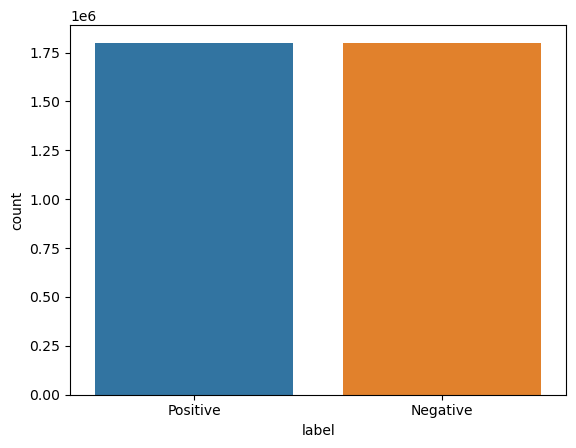

In [9]:
# Countplot of the number of positive and negative reviews
sns.countplot(x=data["label"])

In [10]:
# Create samples of 100 000 positive and 100 000 negative reviews
small_data_positive = data[data['label']=='Positive'].head(100000)
small_data_negative = data[data['label']=='Negative'].head(100000)

In [11]:
# Concate those samples to form a smaller dataframe with balanced data
small_data = pd.concat([small_data_positive, small_data_negative])
small_data = small_data.sample(frac=1, ignore_index=True)
small_data.to_csv('small_data.csv')

# Removing Stop Words

In [12]:
# Removing the stop words with gensim
from gensim.parsing.preprocessing import remove_stopwords

# Create a new column for that preprocessing
small_data['gensim_remove'] = [remove_stopwords(line) for line in tqdm(small_data['text'])]

  0%|          | 0/200000 [00:00<?, ?it/s]

In [13]:
# Removing the stop words with NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the stopwords corpus if not already downloaded
nltk.download('stopwords')

# Download the tokenizer if not already downloaded
nltk.download('punkt')

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

def rmv_stopwords(sentence):

    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Remove the stopwords from the tokenized sentence
    filtered_words = [word for word in words if word.casefold() not in stop_words]

    # Join the filtered words back into a sentence
    filtered_sentence = ' '.join(filtered_words)

    return filtered_sentence

# Create a new column for that preprocessing
small_data['nltk_remove'] = [rmv_stopwords(sentence) for sentence in tqdm(small_data['text'])]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


  0%|          | 0/200000 [00:00<?, ?it/s]

In [14]:
# Display dataframe with new pre-processed columns
small_data

,label,text,gensim_remove,nltk_remove
0,Positive,Gaggia Espresso Machine: This is our (wife an...,Gaggia Espresso Machine: This (wife self) 5th ...,Gaggia Espresso Machine : ( wife self ) 5th es...
1,Positive,"hear the difference: A comparison of ""Living ...","hear difference: A comparison ""Living For City...",hear difference : comparison `` Living City ''...
2,Positive,"Great history: Great history of the1920's, wr...","Great history: Great history the1920's, writte...","Great history : Great history the1920 's , wri..."
3,Positive,liked it: I rented this movie because my mom ...,liked it: I rented movie mom I going Australia...,liked : rented movie mom going Australia looke...
4,Positive,Very entertaining... kids loved it!: Wasn't r...,Very entertaining... kids loved it!: Wasn't ru...,entertaining ... kids loved ! : n't running th...
...,...,...,...,...
199995,Negative,Monkeys Paw: How can anyone like this book???...,Monkeys Paw: How like book??? got worst horror...,Monkeys Paw : anyone like book ? ? ? got worst...
199996,Positive,Melanie C Pics and Bio!: This book is Jam Pac...,Melanie C Pics Bio!: This book Jam Packed pics...,Melanie C Pics Bio ! : book Jam Packed pics Sp...
199997,Negative,Can't Even Bare to read it.....>.<: This book...,Can't Even Bare read it.....>.<: This book act...,Ca n't Even Bare read ... .. > . < : book actu...
199998,Positive,Hacksaw Needed - but a Good Product: This see...,Hacksaw Needed - Good Product: This built stur...,Hacksaw Needed - Good Product : seems well bui...


# Remove Punctuation

In [15]:
# Removing the punctuation with regex
small_data["gensim_remove"] = small_data['gensim_remove'].str.replace(r'[^\w\s]','', regex=True)
small_data["nltk_remove"] = small_data['nltk_remove'].str.replace(r'[^\w\s]','', regex=True)

In [16]:
# Display final dataframe after the first step of pre-processing
small_data

,label,text,gensim_remove,nltk_remove
0,Positive,Gaggia Espresso Machine: This is our (wife an...,Gaggia Espresso Machine This wife self 5th esp...,Gaggia Espresso Machine wife self 5th espre...
1,Positive,"hear the difference: A comparison of ""Living ...",hear difference A comparison Living For City g...,hear difference comparison Living City gold...
2,Positive,"Great history: Great history of the1920's, wr...",Great history Great history the1920s written s...,Great history Great history the1920 s writte...
3,Positive,liked it: I rented this movie because my mom ...,liked it I rented movie mom I going Australia ...,liked rented movie mom going Australia looked...
4,Positive,Very entertaining... kids loved it!: Wasn't r...,Very entertaining kids loved it Wasnt running ...,entertaining kids loved nt running theaters...
...,...,...,...,...
199995,Negative,Monkeys Paw: How can anyone like this book???...,Monkeys Paw How like book got worst horror boo...,Monkeys Paw anyone like book got worst hor...
199996,Positive,Melanie C Pics and Bio!: This book is Jam Pac...,Melanie C Pics Bio This book Jam Packed pics S...,Melanie C Pics Bio book Jam Packed pics Spor...
199997,Negative,Can't Even Bare to read it.....>.<: This book...,Cant Even Bare read it This book actually pret...,Ca nt Even Bare read book actually prett...
199998,Positive,Hacksaw Needed - but a Good Product: This see...,Hacksaw Needed Good Product This built sturdy...,Hacksaw Needed Good Product seems well built...


# Tokenisation

In [17]:
# Install libraries
!pip install keras tensorflow

In [18]:
# Tokenising with Keras
from keras.preprocessing.text import text_to_word_sequence

# Create new columns for that preprocessing
small_data['gensim_token_keras'] = [text_to_word_sequence(sentence) for sentence in tqdm(small_data['gensim_remove'])]
small_data['nltk_token_keras'] = [text_to_word_sequence(sentence) for sentence in tqdm(small_data['nltk_remove'])]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

In [19]:
# Display dataframe
small_data

,label,text,gensim_remove,nltk_remove,gensim_token_keras,nltk_token_keras
0,Positive,Gaggia Espresso Machine: This is our (wife an...,Gaggia Espresso Machine This wife self 5th esp...,Gaggia Espresso Machine wife self 5th espre...,"[gaggia, espresso, machine, this, wife, self, ...","[gaggia, espresso, machine, wife, self, 5th, e..."
1,Positive,"hear the difference: A comparison of ""Living ...",hear difference A comparison Living For City g...,hear difference comparison Living City gold...,"[hear, difference, a, comparison, living, for,...","[hear, difference, comparison, living, city, g..."
2,Positive,"Great history: Great history of the1920's, wr...",Great history Great history the1920s written s...,Great history Great history the1920 s writte...,"[great, history, great, history, the1920s, wri...","[great, history, great, history, the1920, s, w..."
3,Positive,liked it: I rented this movie because my mom ...,liked it I rented movie mom I going Australia ...,liked rented movie mom going Australia looked...,"[liked, it, i, rented, movie, mom, i, going, a...","[liked, rented, movie, mom, going, australia, ..."
4,Positive,Very entertaining... kids loved it!: Wasn't r...,Very entertaining kids loved it Wasnt running ...,entertaining kids loved nt running theaters...,"[very, entertaining, kids, loved, it, wasnt, r...","[entertaining, kids, loved, nt, running, theat..."
...,...,...,...,...,...,...
199995,Negative,Monkeys Paw: How can anyone like this book???...,Monkeys Paw How like book got worst horror boo...,Monkeys Paw anyone like book got worst hor...,"[monkeys, paw, how, like, book, got, worst, ho...","[monkeys, paw, anyone, like, book, got, worst,..."
199996,Positive,Melanie C Pics and Bio!: This book is Jam Pac...,Melanie C Pics Bio This book Jam Packed pics S...,Melanie C Pics Bio book Jam Packed pics Spor...,"[melanie, c, pics, bio, this, book, jam, packe...","[melanie, c, pics, bio, book, jam, packed, pic..."
199997,Negative,Can't Even Bare to read it.....>.<: This book...,Cant Even Bare read it This book actually pret...,Ca nt Even Bare read book actually prett...,"[cant, even, bare, read, it, this, book, actua...","[ca, nt, even, bare, read, book, actually, pre..."
199998,Positive,Hacksaw Needed - but a Good Product: This see...,Hacksaw Needed Good Product This built sturdy...,Hacksaw Needed Good Product seems well built...,"[hacksaw, needed, good, product, this, built, ...","[hacksaw, needed, good, product, seems, well, ..."


In [20]:
# Tokenising with NLTK
from nltk.tokenize import word_tokenize

# Create new columns for that preprocessing
small_data['gensim_token_nltk'] = [word_tokenize(sentence) for sentence in tqdm(small_data['gensim_remove'])]
small_data['nltk_token_nltk'] = [word_tokenize(sentence) for sentence in tqdm(small_data['nltk_remove'])]

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

In [21]:
# Display final dataframe after second step of pre-processing
small_data

,label,text,gensim_remove,nltk_remove,gensim_token_keras,nltk_token_keras,gensim_token_nltk,nltk_token_nltk
0,Positive,Gaggia Espresso Machine: This is our (wife an...,Gaggia Espresso Machine This wife self 5th esp...,Gaggia Espresso Machine wife self 5th espre...,"[gaggia, espresso, machine, this, wife, self, ...","[gaggia, espresso, machine, wife, self, 5th, e...","[Gaggia, Espresso, Machine, This, wife, self, ...","[Gaggia, Espresso, Machine, wife, self, 5th, e..."
1,Positive,"hear the difference: A comparison of ""Living ...",hear difference A comparison Living For City g...,hear difference comparison Living City gold...,"[hear, difference, a, comparison, living, for,...","[hear, difference, comparison, living, city, g...","[hear, difference, A, comparison, Living, For,...","[hear, difference, comparison, Living, City, g..."
2,Positive,"Great history: Great history of the1920's, wr...",Great history Great history the1920s written s...,Great history Great history the1920 s writte...,"[great, history, great, history, the1920s, wri...","[great, history, great, history, the1920, s, w...","[Great, history, Great, history, the1920s, wri...","[Great, history, Great, history, the1920, s, w..."
3,Positive,liked it: I rented this movie because my mom ...,liked it I rented movie mom I going Australia ...,liked rented movie mom going Australia looked...,"[liked, it, i, rented, movie, mom, i, going, a...","[liked, rented, movie, mom, going, australia, ...","[liked, it, I, rented, movie, mom, I, going, A...","[liked, rented, movie, mom, going, Australia, ..."
4,Positive,Very entertaining... kids loved it!: Wasn't r...,Very entertaining kids loved it Wasnt running ...,entertaining kids loved nt running theaters...,"[very, entertaining, kids, loved, it, wasnt, r...","[entertaining, kids, loved, nt, running, theat...","[Very, entertaining, kids, loved, it, Wasnt, r...","[entertaining, kids, loved, nt, running, theat..."
...,...,...,...,...,...,...,...,...
199995,Negative,Monkeys Paw: How can anyone like this book???...,Monkeys Paw How like book got worst horror boo...,Monkeys Paw anyone like book got worst hor...,"[monkeys, paw, how, like, book, got, worst, ho...","[monkeys, paw, anyone, like, book, got, worst,...","[Monkeys, Paw, How, like, book, got, worst, ho...","[Monkeys, Paw, anyone, like, book, got, worst,..."
199996,Positive,Melanie C Pics and Bio!: This book is Jam Pac...,Melanie C Pics Bio This book Jam Packed pics S...,Melanie C Pics Bio book Jam Packed pics Spor...,"[melanie, c, pics, bio, this, book, jam, packe...","[melanie, c, pics, bio, book, jam, packed, pic...","[Melanie, C, Pics, Bio, This, book, Jam, Packe...","[Melanie, C, Pics, Bio, book, Jam, Packed, pic..."
199997,Negative,Can't Even Bare to read it.....>.<: This book...,Cant Even Bare read it This book actually pret...,Ca nt Even Bare read book actually prett...,"[cant, even, bare, read, it, this, book, actua...","[ca, nt, even, bare, read, book, actually, pre...","[Cant, Even, Bare, read, it, This, book, actua...","[Ca, nt, Even, Bare, read, book, actually, pre..."
199998,Positive,Hacksaw Needed - but a Good Product: This see...,Hacksaw Needed Good Product This built sturdy...,Hacksaw Needed Good Product seems well built...,"[hacksaw, needed, good, product, this, built, ...","[hacksaw, needed, good, product, seems, well, ...","[Hacksaw, Needed, Good, Product, This, built, ...","[Hacksaw, Needed, Good, Product, seems, well, ..."


# Lemmatisation

In [22]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [23]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [24]:
# Lemmatising with NLTK

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
  tag = nltk.pos_tag([word])[0][1][0].upper()
  tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

nltk_lemma = []

for token in tqdm(small_data['gensim_token_keras']):
  lemma_list = []
  for word in token:
    lemma_list.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

  nltk_lemma.append(lemma_list)

# Create a new column for that preprocessing
small_data["nltk_gensim_token_keras"] = nltk_lemma

  0%|          | 0/200000 [00:00<?, ?it/s]

In [25]:
nltk_lemma = []

for token in tqdm(small_data['nltk_token_keras']):
  lemma_list = []
  for word in token:
    lemma_list.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

  nltk_lemma.append(lemma_list)

# Create a new column for that preprocessing
small_data["nltk_nltk_token_keras"] = nltk_lemma

  0%|          | 0/200000 [00:00<?, ?it/s]

In [26]:
nltk_lemma = []

for token in tqdm(small_data['gensim_token_nltk']):
  lemma_list = []
  for word in token:
    lemma_list.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

  nltk_lemma.append(lemma_list)

# Create a new column for that preprocessing
small_data["nltk_gensim_token_nltk"] = nltk_lemma

  0%|          | 0/200000 [00:00<?, ?it/s]

In [27]:
nltk_lemma = []

for token in tqdm(small_data['nltk_token_nltk']):
  lemma_list = []
  for word in token:
    lemma_list.append(lemmatizer.lemmatize(word, get_wordnet_pos(word)))

  nltk_lemma.append(lemma_list)

# Create a new column for that preprocessing
small_data["nltk_nltk_token_nltk"] = nltk_lemma

  0%|          | 0/200000 [00:00<?, ?it/s]

In [28]:
# Display final dataframe after lemmatisation
small_data

,label,text,gensim_remove,nltk_remove,gensim_token_keras,nltk_token_keras,gensim_token_nltk,nltk_token_nltk,nltk_gensim_token_keras,nltk_nltk_token_keras,nltk_gensim_token_nltk,nltk_nltk_token_nltk
0,Positive,Gaggia Espresso Machine: This is our (wife an...,Gaggia Espresso Machine This wife self 5th esp...,Gaggia Espresso Machine wife self 5th espre...,"[gaggia, espresso, machine, this, wife, self, ...","[gaggia, espresso, machine, wife, self, 5th, e...","[Gaggia, Espresso, Machine, This, wife, self, ...","[Gaggia, Espresso, Machine, wife, self, 5th, e...","[gaggia, espresso, machine, this, wife, self, ...","[gaggia, espresso, machine, wife, self, 5th, e...","[Gaggia, Espresso, Machine, This, wife, self, ...","[Gaggia, Espresso, Machine, wife, self, 5th, e..."
1,Positive,"hear the difference: A comparison of ""Living ...",hear difference A comparison Living For City g...,hear difference comparison Living City gold...,"[hear, difference, a, comparison, living, for,...","[hear, difference, comparison, living, city, g...","[hear, difference, A, comparison, Living, For,...","[hear, difference, comparison, Living, City, g...","[hear, difference, a, comparison, living, for,...","[hear, difference, comparison, living, city, g...","[hear, difference, A, comparison, Living, For,...","[hear, difference, comparison, Living, City, g..."
2,Positive,"Great history: Great history of the1920's, wr...",Great history Great history the1920s written s...,Great history Great history the1920 s writte...,"[great, history, great, history, the1920s, wri...","[great, history, great, history, the1920, s, w...","[Great, history, Great, history, the1920s, wri...","[Great, history, Great, history, the1920, s, w...","[great, history, great, history, the1920s, wri...","[great, history, great, history, the1920, s, w...","[Great, history, Great, history, the1920s, wri...","[Great, history, Great, history, the1920, s, w..."
3,Positive,liked it: I rented this movie because my mom ...,liked it I rented movie mom I going Australia ...,liked rented movie mom going Australia looked...,"[liked, it, i, rented, movie, mom, i, going, a...","[liked, rented, movie, mom, going, australia, ...","[liked, it, I, rented, movie, mom, I, going, A...","[liked, rented, movie, mom, going, Australia, ...","[like, it, i, rent, movie, mom, i, go, austral...","[like, rent, movie, mom, go, australia, look, ...","[like, it, I, rent, movie, mom, I, go, Austral...","[like, rent, movie, mom, go, Australia, look, ..."
4,Positive,Very entertaining... kids loved it!: Wasn't r...,Very entertaining kids loved it Wasnt running ...,entertaining kids loved nt running theaters...,"[very, entertaining, kids, loved, it, wasnt, r...","[entertaining, kids, loved, nt, running, theat...","[Very, entertaining, kids, loved, it, Wasnt, r...","[entertaining, kids, loved, nt, running, theat...","[very, entertain, kid, love, it, wasnt, run, t...","[entertain, kid, love, nt, run, theater, come,...","[Very, entertain, kid, love, it, Wasnt, run, t...","[entertain, kid, love, nt, run, theater, come,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,Negative,Monkeys Paw: How can anyone like this book???...,Monkeys Paw How like book got worst horror boo...,Monkeys Paw anyone like book got worst hor...,"[monkeys, paw, how, like, book, got, worst, ho...","[monkeys, paw, anyone, like, book, got, worst,...","[Monkeys, Paw, How, like, book, got, worst, ho...","[Monkeys, Paw, anyone, like, book, got, worst,...","[monkey, paw, how, like, book, get, bad, horro...","[monkey, paw, anyone, like, book, get, bad, ho...","[Monkeys, Paw, How, like, book, get, bad, horr...","[Monkeys, Paw, anyone, like, book, get, bad, h..."
199996,Positive,Melanie C Pics and Bio!: This book is Jam Pac...,Melanie C Pics Bio This book Jam Packed pics S...,Melanie C Pics Bio book Jam Packed pics Spor...,"[melanie, c, pics, bio, this, book, jam, packe...","[melanie, c, pics, bio, book, jam, packed, pic...","[Melanie, C, Pics, Bio, This, bo

In [29]:
# Stemming with NLTK
import nltk
from nltk.stem import PorterStemmer, SnowballStemmer

porter_stemmer = PorterStemmer()

nltk_stemm = []

for token in tqdm(small_data['gensim_token_keras']):
  lemma_list = []
  for word in token:
    lemma_list.append(porter_stemmer.stem(word))

  nltk_stemm.append(lemma_list)

# Create a new column for that preprocessing
small_data["nltk_stemmer_gensim_token_keras"] = nltk_stemm

  0%|          | 0/200000 [00:00<?, ?it/s]

In [30]:
nltk_stemm = []

for token in tqdm(small_data['nltk_token_keras']):
  lemma_list = []
  for word in token:
    lemma_list.append(porter_stemmer.stem(word))

  nltk_stemm.append(lemma_list)

# Create a new column for that preprocessing
small_data["nltk_stemmer_nltk_token_keras"] = nltk_stemm

  0%|          | 0/200000 [00:00<?, ?it/s]

In [31]:
nltk_stemm = []

for token in tqdm(small_data['gensim_token_nltk']):
  lemma_list = []
  for word in token:
    lemma_list.append(porter_stemmer.stem(word))

  nltk_stemm.append(lemma_list)

# Create a new column for that preprocessing
small_data["nltk_stemmer_gensim_token_nltk"] = nltk_stemm

  0%|          | 0/200000 [00:00<?, ?it/s]

In [32]:
nltk_stemm = []

for token in tqdm(small_data['nltk_token_nltk']):
  lemma_list = []
  for word in token:
    lemma_list.append(porter_stemmer.stem(word))

  nltk_stemm.append(lemma_list)

# Create a new column for that preprocessing
small_data["nltk_stemmer_nltk_token_nltk"] = nltk_stemm

  0%|          | 0/200000 [00:00<?, ?it/s]

In [33]:
# Display final dataframe after stemming
small_data

,label,text,gensim_remove,nltk_remove,gensim_token_keras,nltk_token_keras,gensim_token_nltk,nltk_token_nltk,nltk_gensim_token_keras,nltk_nltk_token_keras,nltk_gensim_token_nltk,nltk_nltk_token_nltk,nltk_stemmer_gensim_token_keras,nltk_stemmer_nltk_token_keras,nltk_stemmer_gensim_token_nltk,nltk_stemmer_nltk_token_nltk
0,Positive,Gaggia Espresso Machine: This is our (wife an...,Gaggia Espresso Machine This wife self 5th esp...,Gaggia Espresso Machine wife self 5th espre...,"[gaggia, espresso, machine, this, wife, self, ...","[gaggia, espresso, machine, wife, self, 5th, e...","[Gaggia, Espresso, Machine, This, wife, self, ...","[Gaggia, Espresso, Machine, wife, self, 5th, e...","[gaggia, espresso, machine, this, wife, self, ...","[gaggia, espresso, machine, wife, self, 5th, e...","[Gaggia, Espresso, Machine, This, wife, self, ...","[Gaggia, Espresso, Machine, wife, self, 5th, e...","[gaggia, espresso, machin, thi, wife, self, 5t...","[gaggia, espresso, machin, wife, self, 5th, es...","[gaggia, espresso, machin, thi, wife, self, 5t...","[gaggia, espresso, machin, wife, self, 5th, es..."
1,Positive,"hear the difference: A comparison of ""Living ...",hear difference A comparison Living For City g...,hear difference comparison Living City gold...,"[hear, difference, a, comparison, living, for,...","[hear, difference, comparison, living, city, g...","[hear, difference, A, comparison, Living, For,...","[hear, difference, comparison, Living, City, g...","[hear, difference, a, comparison, living, for,...","[hear, difference, comparison, living, city, g...","[hear, difference, A, comparison, Living, For,...","[hear, difference, comparison, Living, City, g...","[hear, differ, a, comparison, live, for, citi,...","[hear, differ, comparison, live, citi, gold, d...","[hear, differ, A, comparison, live, for, citi,...","[hear, differ, comparison, live, citi, gold, d..."
2,Positive,"Great history: Great history of the1920's, wr...",Great history Great history the1920s written s...,Great history Great history the1920 s writte...,"[great, history, great, history, the1920s, wri...","[great, history, great, history, the1920, s, w...","[Great, history, Great, history, the1920s, wri...","[Great, history, Great, history, the1920, s, w...","[great, history, great, history, the1920s, wri...","[great, history, great, history, the1920, s, w...","[Great, history, Great, history, the1920s, wri...","[Great, history, Great, history, the1920, s, w...","[great, histori, great, histori, the1920, writ...","[great, histori, great, histori, the1920, s, w...","[great, histori, great, histori, the1920, writ...","[great, histori, great, histori, the1920, s, w..."
3,Positive,liked it: I rented this movie because my mom ...,liked it I rented movie mom I going Australia ...,liked rented movie mom going Australia looked...,"[liked, it, i, rented, movie, mom, i, going, a...","[liked, rented, movie, mom, going, australia, ...","[liked, it, I, rented, movie, mom, I, going, A...","[liked, rented, movie, mom, going, Australia, ...","[like, it, i, rent, movie, mom, i, go, austral...","[like, rent, movie, mom, go, australia, look, ...","[like, it, I, rent, movie, mom, I, go, Austral...","[like, rent, movie, mom, go, Australia, look, ...","[like, it, i, rent, movi, mom, i, go, australi...","[like, rent, movi, mom, go, australia, look, m...","[like, it, I, rent, movi, mom, I, go, australi...","[like, rent, movi, mom, go, australia, look, m..."
4,Positive,Very entertaining... kids loved it!: Wasn't r...,Very entertaining kids loved it Wasnt running ...,entertaining kids loved nt running theaters...,"[very, entertaining, kids, loved, it, wasnt, r...","[entertaining, kids, loved, nt, running, theat...","[Very, entertaining, kids, loved, it, Wasnt, r...","[entertaining, kids, loved, nt, running, theat...","[very, entertain, kid, love, it, wasnt, run, t...","[entertain, kid, love, nt, run, theater, come,...","[Very, entertain, kid, love, it, Wasnt, run, t...","[entertain, kid, love, nt,

In [34]:
# Save the dataframe to csv file
path = 'small_data_preprocessed.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  small_data.to_csv(f, index=False)